## <center>RNN for Time Series</center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [2]:
df = pd.read_csv('C:/Users/Lenovo/Desktop/Python/Deep Learning/Data Sets/TensorFlow/RSCCASN.csv',index_col='DATE', parse_dates=True)
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [3]:
df.columns = ['Sales']
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


<AxesSubplot:xlabel='DATE'>

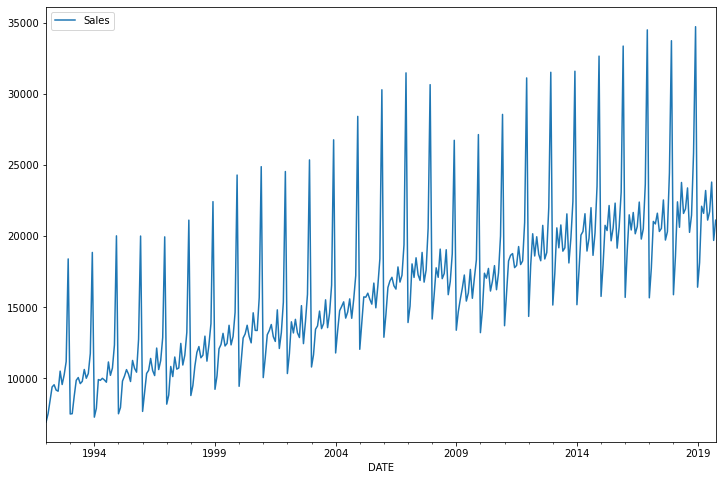

In [4]:
df.plot(figsize=(12,8))

#### Train Test Split

In [5]:
len(df)

334

Data is monthly, let's forecast 1.5 years into the future.

In [6]:
len(df)- 18

316

In [7]:
test_size = 18

In [8]:
test_ind = len(df)- test_size

In [9]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

#### Scale Data

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

#### Time Series Generator

In [12]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [13]:
# Let's redefine to get 12 months back and then predict the next month out
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [14]:
# What does the first batch look like?
X,y = generator[0]

In [15]:
scaled_train[:length+1]

array([[0.        ],
       [0.02127505],
       [0.05580163],
       [0.08942056],
       [0.09512053],
       [0.08146965],
       [0.07860151],
       [0.12979233],
       [0.09566512],
       [0.1203892 ],
       [0.15426227],
       [0.41595266],
       [0.02047633]])

In [16]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


### Create the Model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [18]:
# define model
n_features = 1


model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [20]:
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [22]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [23]:
model.fit_generator(generator,epochs=50,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/50


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17068\1888584902.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=50,


304/304 [==============================] - 2s 3ms/step - loss: 0.0276 - val_loss: 0.0081
Epoch 2/50
304/304 [==============================] - 1s 3ms/step - loss: 0.0182 - val_loss: 0.0029
Epoch 3/50
304/304 [==============================] - 1s 3ms/step - loss: 0.0110 - val_loss: 8.5008e-04
Epoch 4/50
304/304 [==============================] - 1s 3ms/step - loss: 0.0061 - val_loss: 0.0022
Epoch 5/50
304/304 [==============================] - 1s 3ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 6/50
304/304 [==============================] - 1s 3ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 7/50
304/304 [==============================] - 1s 3ms/step - loss: 0.0016 - val_loss: 4.3257e-04
Epoch 8/50
304/304 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 9/50
304/304 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 1.9670e-04
Epoch 10/50
304/304 [==============================] - 1s 3ms/step - loss: 0.0012 - val_loss: 0.002

<AxesSubplot:>

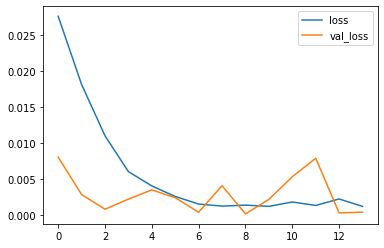

In [24]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [25]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 14ms/step


### Testing the model

In [26]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17068\229408474.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


,Sales,Predictions
DATE,,
2018-05-01,23764,21749.940482
2018-06-01,21589,20637.201507
2018-07-01,21919,20870.609152
2018-08-01,23381,22598.477501
2018-09-01,20260,20114.348352


<AxesSubplot:xlabel='DATE'>

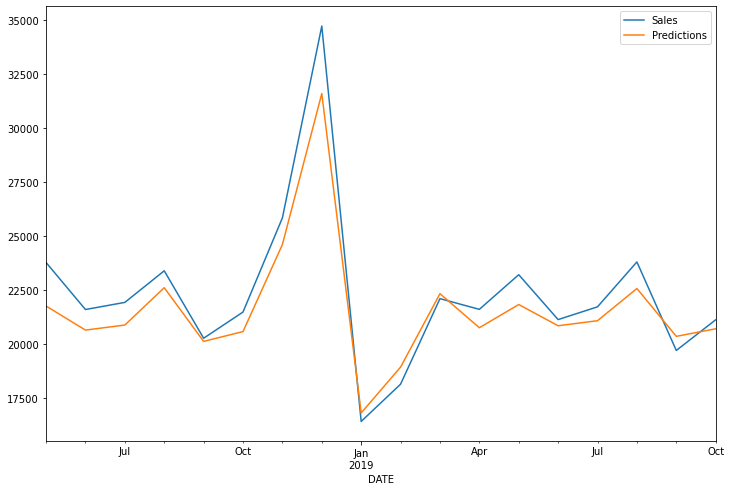

In [27]:
test.plot(figsize=(12,8))

### Retrain and Forecasting

In [28]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [29]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [30]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=16)

Epoch 1/16


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17068\162762269.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=16)


322/322 [==============================] - 2s 3ms/step - loss: 0.0232
Epoch 2/16
322/322 [==============================] - 1s 3ms/step - loss: 0.0163
Epoch 3/16
322/322 [==============================] - 1s 3ms/step - loss: 0.0084
Epoch 4/16
322/322 [==============================] - 1s 3ms/step - loss: 0.0044
Epoch 5/16
322/322 [==============================] - 1s 3ms/step - loss: 0.0037
Epoch 6/16
322/322 [==============================] - 1s 3ms/step - loss: 0.0015
Epoch 7/16
322/322 [==============================] - 1s 3ms/step - loss: 0.0016
Epoch 8/16
322/322 [==============================] - 1s 3ms/step - loss: 0.0018
Epoch 9/16
322/322 [==============================] - 1s 3ms/step - loss: 0.0013
Epoch 10/16
322/322 [==============================] - 1s 3ms/step - loss: 0.0013
Epoch 11/16
322/322 [==============================] - 1s 3ms/step - loss: 0.0013
Epoch 12/16
322/322 [==============================] - 1s 3ms/step - loss: 0.0020
Epoch 13/16
322/322 [===============

In [31]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    current_pred = model.predict(current_batch)[0]  
    forecast.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 16ms/step


In [32]:
forecast = scaler.inverse_transform(forecast)

#### Creating new timestamp index with pandas.

In [33]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [34]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [35]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [36]:
forecast_df

,Forecast
2019-11-01,25872.549601
2019-12-01,35832.638450
2020-01-01,16219.729923
2020-02-01,18232.579042
2020-03-01,21941.775725
2020-04-01,21467.116152
2020-05-01,23022.119683
2020-06-01,21019.228601
2020-07-01,21578.279067
2020-08-01,23579.738543


<AxesSubplot:>

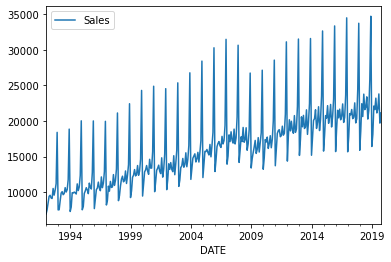

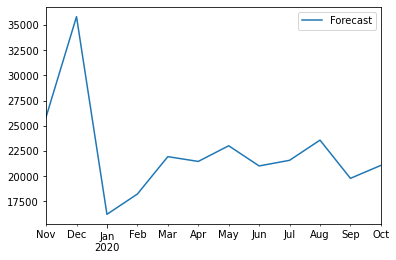

In [37]:
df.plot()
forecast_df.plot()

<AxesSubplot:xlabel='DATE'>

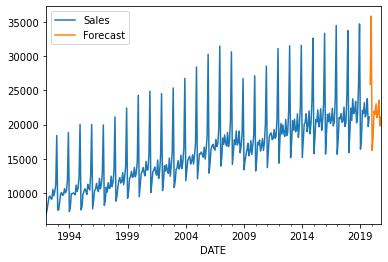

In [38]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

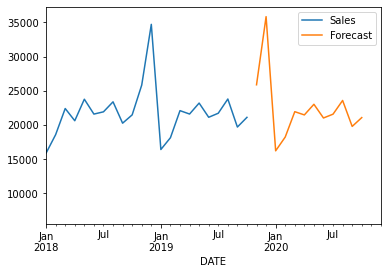

In [39]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')